In [1]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt

In this notebook we merge US census data into a single dataset covering a period from 1999 to 2023, thus matching our wine datasets period.

## Parents with coresident children

In [2]:
children_data = pd.read_excel(
    "us_census_data/ad2.xls", 
    sheet_name='Table AD-2', skiprows=73,
    names=["Year", "Num w/ small children", "2:Unnamed", "Married spouse present", 
           "Cohabiting", "No partner present", "6:Unnamed", 
           "7:Unnamed", "8:Unnamed", "9:Unnamed"],
    usecols=["Year", "Num w/ small children"]
)
children_data.shape

(76, 2)

Only consider the 17 most recent years

In [3]:
children_data = children_data[:17].copy()

Remove non-numerical characters clutering the year

In [4]:
children_data["Year"] = children_data["Year"].apply(lambda x: re.sub("[^0-9]+", "", x)).astype(int)

Convert total to true scale

In [5]:
children_data["Num w/ small children"] *= 1000

In [6]:
children_data = children_data.drop_duplicates(subset=["Year"], keep="first")
children_data = children_data.reset_index(drop=True)

In [7]:
children_data = children_data.sort_values(by="Year")

In [8]:
children_data.head()

,Year,Num w/ small children
15,2007,31652000.0
14,2008,30539000.0
13,2009,30497000.0
12,2010,30508000.0
11,2011,30381000.0


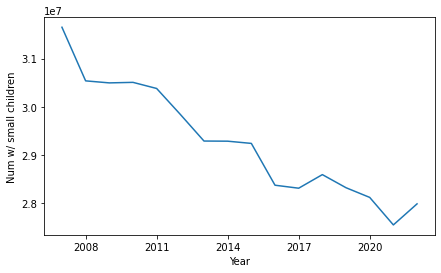

In [9]:
plt.figure(figsize=(7,4))
sns.lineplot(data=children_data, x="Year", y="Num w/ small children")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

## Households by Total Income

In [10]:
income_data = pd.read_excel(
    "us_census_data/tableA2.xlsx", 
    sheet_name='tableA2', skiprows=5,
    names=["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "Median Income", "13", "Mean Income", "5"],
    usecols=["Year", "Median Income", "Mean Income"]
)
income_data.shape

(496, 3)

Only consider the most recent year from 1999

In [11]:
income_data = income_data[:26].copy()

Clean year column

In [12]:
income_data["Year"] = income_data["Year"].apply(lambda x: re.search("(\d{4})", str(x)).group(1))
income_data = income_data.drop_duplicates(subset=["Year"]).astype(int)

In [13]:
income_data = income_data.sort_values(by="Year")

In [14]:
income_data.head()

,Year,Median Income,Mean Income
25,1999,67650,90990
24,2000,67470,91810
23,2001,66360,91470
22,2002,65820,89790
21,2003,65860,89810


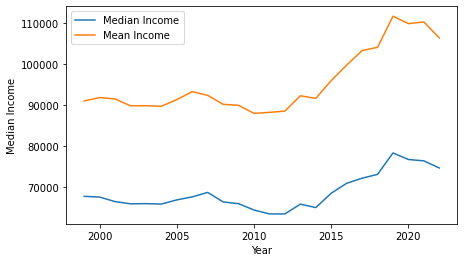

In [15]:
plt.figure(figsize=(7,4))
sns.lineplot(data=income_data, x="Year", y="Median Income", label="Median Income")
sns.lineplot(data=income_data, x="Year", y="Mean Income", label="Mean Income")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=6))

## Population by age

In [16]:
def extract_age_range(x):
    match = re.findall("\d+", str(x))
    a = int(match[0])
    b = int(match[1]) if len(match) > 1 else None 
    return a, b

In [17]:
def categorize_age(x):
    a,b = extract_age_range(x)
    if a >= 60:
        return "Seniors"
    if a >= 25:
        return "Adults"
    if a >= 20:
        return "Young Adults"
    if a >= 15:
        return "Teens"
    return "Kids"

In [18]:
age_data = None

for file_name in os.listdir("us_census_data/age"):
    if re.search("(\d{4})agesex_table1\.xlsx", file_name):
        match = re.search("(\d{4})agesex_table1", file_name)
        year = int(match.group(1))
        sheet_name = f"{year}agesex_table1"
        skiprows = 17
    elif re.search("(\d{4})gender_table1\.(xlsx|xls)", file_name):
        match = re.search("(\d{4})gender_table1", file_name)
        year = int(match.group(1))
        if year in [2010, 2011, 2012, 2013]:
            sheet_name = "Age Sex Race HO"
        elif year in [2014]:
            sheet_name = "Age Sex Race HO tab1"
        elif year in [2007, 2008, 2009]:
            sheet_name = "Sheet1"
        else:
            sheet_name = "Age Sex"
        skiprows = 18
    elif re.search("(\d{4})gender_table1(\-|\.)1\.xls", file_name):
        match = re.search("(\d{4})gender_table1(\-|\.)1", file_name)
        year = int(match.group(1))
        sheet_name = f"{year}gender_table1.1"
        skiprows = 14
    else:
        print(f"Warning: Could not parse file '{file_name}'")
        continue
    
    row = pd.read_excel(
        f"us_census_data/age/{file_name}", 
        sheet_name=sheet_name, skiprows=7,
        names=["Age", "Total", "2", "3", "4", "5", "6"],
        usecols=["Age", "Total"]
    )
    
    row = row[:skiprows]
    row = row.dropna(subset=["Age"])
    row["Total"] = row["Total"].astype(float)
    row["Total"] *= 1000
    row["Age"] = row["Age"].apply(lambda x: re.search("(\d{1,2} (to \d{1,2} )?years( and over)?)", str(x)).group(1))
    row["Age_Group"] = row["Age"].apply(categorize_age)
    
    # Aggregate data
    agg = row[["Age_Group", "Total"]].groupby("Age_Group").sum()
    agg = agg.T
    agg.columns.name = None
    agg.columns = [f"Num {col}" for col in agg.columns]
    agg["Year"] = year
    
    if age_data is not None:
        age_data = pd.concat([age_data, agg])
    else:
        age_data = agg
        
age_data = age_data.reset_index(drop=True).sort_values(by="Year")

In [19]:
age_data["Total Population"] = age_data.sum(axis=1)

In [20]:
age_data.head()

,Num Adults,Num Kids,Num Seniors,Num Teens,Num Young Adults,Year,Total Population
0,150950000.0,60684000.0,34234000.0,20181000.0,19884000.0,2003,285935003.0
1,152217000.0,60752000.0,34659000.0,20313000.0,20339000.0,2004,288282004.0
2,154158000.0,40467000.0,35210000.0,20662000.0,20408000.0,2005,270907005.0
3,156380000.0,60640000.0,35505000.0,20916000.0,20393000.0,2006,293836006.0
4,144314000.0,40274000.0,50006000.0,21170000.0,20532000.0,2007,276298007.0


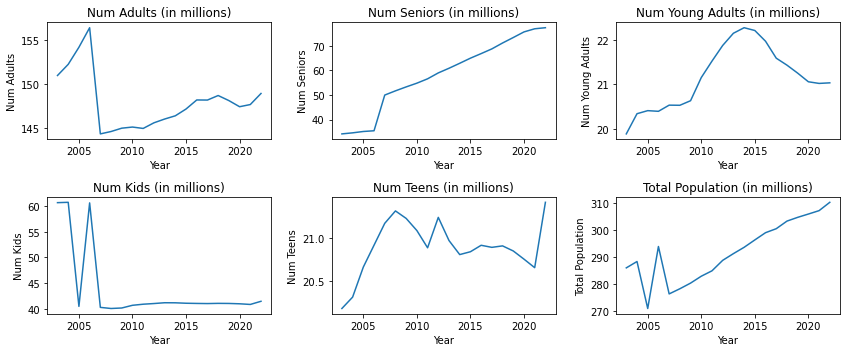

In [21]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(12,5))
age_cols = age_data.columns.values.tolist()
age_cols.remove("Year")
for index,col in enumerate(age_cols):
    j = index//2
    i = index%2
    sns.lineplot(data=age_data/1000000, x=age_data["Year"], y=col, ax=ax[i][j])
    ax[i][j].set_title(f"{col} (in millions)")
    #ax[i].set_ylim(0, (age_data[col]/1000000).max() + 15)
plt.tight_layout()

## Educational Attainment

In [22]:
education_data = None

for file_name in os.listdir("us_census_data/education"):
    year = int(re.search("^(\d{4})[a-zA-Z]+", file_name).group(1))
    
    match_0 = re.search("(\d{4})agesex_table3\.(xlsx|xls)", file_name)
    match_1 = re.search("(\d{4})gender_table3\.(xlsx|xls)", file_name)
    match_2 = re.search("(\d{4})gender_table11\.(xlsx|xls)", file_name)
    match_3 = re.search("(\d{4})gender_table5\.(xlsx|xls)", file_name)
    
    if match_0 or match_2 or match_3 or (year in [2013, 2014, 2015, 2016, 2017, 2018, 2019] and match_1):
        if match_2 and year in [2007, 2008, 2009]:
            sheet_name = "Sheet1"
        elif match_2 or match_3 or (match_1 and year in [2013, 2015, 2016, 2017, 2018, 2019]):
            sheet_name = "Educational Attainment"
        elif match_1 and year == 2014:
            sheet_name = "Educational Attainment tab3"
        else:
            sheet_name = f"{year}agesex_table3"
            
        skiprows = 6
        if year in [2015, 2016]:
            skiprows = 7
        
        row = pd.read_excel(
            f"us_census_data/education/{file_name}", 
            sheet_name=sheet_name, skiprows=skiprows,
            names=["Age", "0", "1", "Basic education", "3", "High School", "5", "Some College", 
                   "7", "Bachelor's degree", "9", "Advanced degree", "11"],
            usecols=["Basic education", "High School", "Some College", "Bachelor's degree", "Advanced degree"]
        )
        
        row = row[:1]
        row = row.astype(float)
        row *= 1000
        row["Year"] = year
    elif match_1:
        sheet_name = f"{year}gender_table3"
        
        row = pd.read_excel(
            f"us_census_data/education/{file_name}", 
            sheet_name=sheet_name, skiprows=8,
            names=["Level", "Total", "2", "3", "4", "5", "6"],
            usecols=["Level", "Total"]
        )
        
        row = row[:4]
        row["Level"] = row["Level"].str.replace("\.", "").str.strip()
        row = row.set_index("Level")
        row = row.T
        row.columns.name = None
        row = row.rename(columns={"High school graduate": "High School", 
                                  "Some college or associate's degree": "Some College"})
        row *= 1000
        row["Year"] = year
    else:
        print(f"Warning: Could not parse file '{file_name}'")
        continue
    
    if education_data is not None:
        education_data = pd.concat([education_data, row])
    else:
        education_data = row
        
education_data = education_data.reset_index(drop=True).sort_values(by="Year")

C:\Users\ngoum\AppData\Local\Temp\ipykernel_34912\344244444.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  row["Level"] = row["Level"].str.replace("\.", "").str.strip()
C:\Users\ngoum\AppData\Local\Temp\ipykernel_34912\344244444.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  row["Level"] = row["Level"].str.replace("\.", "").str.strip()
C:\Users\ngoum\AppData\Local\Temp\ipykernel_34912\344244444.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  row["Level"] = row["Level"].str.replace("\.", "").str.strip()


In [23]:
education_data.head()

,High School,Some College,Bachelor's degree,Advanced degree,Year,Basic education
0,68302000.0,58609000.0,35994000.0,18105000.0,2004,NaN
1,69446000.0,59276000.0,36520000.0,18225000.0,2005,NaN
2,69548000.0,60615000.0,37334000.0,18734000.0,2006,NaN
3,70266000.0,60681000.0,38940000.0,19364000.0,2007,46769000.0
4,69702000.0,62875000.0,40094000.0,20396000.0,2008,45080000.0


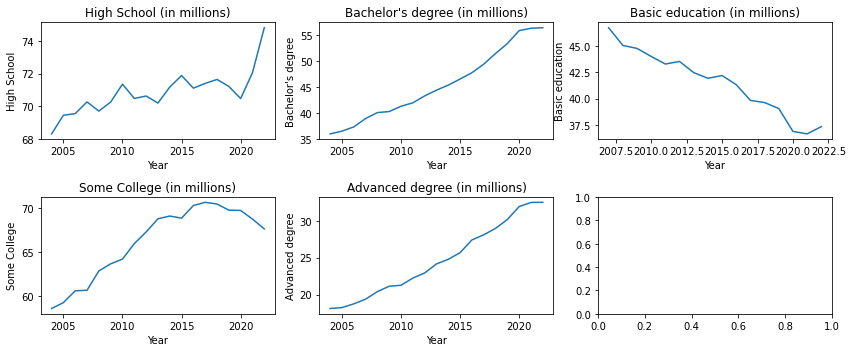

In [24]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=(12,5))
education_cols = education_data.columns.values.tolist()
education_cols.remove("Year")
for index,col in enumerate(education_cols):
    j = index//2
    i = index%2
    sns.lineplot(data=education_data/1000000, x=education_data["Year"], y=col, ax=ax[i][j])
    ax[i][j].set_title(f"{col} (in millions)")
    #ax[i].set_ylim(0, (age_data[col]/1000000).max() + 15)
plt.tight_layout()

## Merged Dataset

In [25]:
merged_data = pd.merge(children_data, income_data, on='Year', how="outer")
merged_data = pd.merge(merged_data, age_data, on='Year', how="outer")
merged_data = pd.merge(merged_data, education_data, on='Year', how="outer")
merged_data.shape

(24, 15)

In [26]:
merged_data = merged_data.sort_values(by="Year")
merged_data = merged_data.reset_index(drop=True)

In [27]:
merged_data.head(10)

,Year,Num w/ small children,Median Income,Mean Income,Num Adults,Num Kids,Num Seniors,Num Teens,Num Young Adults,Total Population,High School,Some College,Bachelor's degree,Advanced degree,Basic education
0,1999,NaN,67650,90990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,NaN,67470,91810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,NaN,66360,91470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002,NaN,65820,89790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,NaN,65860,89810,150950000.0,60684000.0,34234000.0,20181000.0,19884000.0,285935003.0,NaN,NaN,NaN,NaN,NaN
5,2004,NaN,65760,89690,152217000.0,60752000.0,34659000.0,20313000.0,20339000.0,288282004.0,68302000.0,58609000.0,35994000.0,18105000.0,NaN
6,2005,NaN,66780,91310,154158000.0,40467000.0,35210000.0,20662000.0,20408000.0,270907005.0,69446000.0,59276000.0,36520000.0,18225000.0,NaN
7,2006,NaN,67520,93260,156380000.0,60640000.0,35505000.0,20916000.0,20393000.0,293836006.0,69548000.0,60615000.0,37334000.0,18734000.0,NaN
8,2007,31652000.0,68610,92340,144314000.0,40274000.0,50006000.0,21170000.0,20532000.0,276298007.0,70266000.0,60681000.0,38940000.0,19364000.0,46769000.0
9,2008,30539000.0,66280,90150,144584000.0,40056000.0,51720000.0,21314000.0,20529000.0,278205008.0,69702000.0,62875000.0,40094000.0,20396000.0,45080000.0


In [28]:
merged_data.to_csv("us_census_merged.csv", index=False)

## Correlation Table

In [29]:
def calculate_correlation(dataframe):
    # Calculate correlation matrix for the given DataFrame
    correlation_matrix = dataframe.corr()
    return correlation_matrix

In [30]:
def visualize_correlation(correlation_matrix):
    # Visualize the correlation matrix using a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
    plt.title('Correlation Between Variables')
    #plt.xlabel('Time Series')
    #plt.ylabel('Time Series')
    plt.show()

In [31]:
correlation_matrix = calculate_correlation(merged_data)

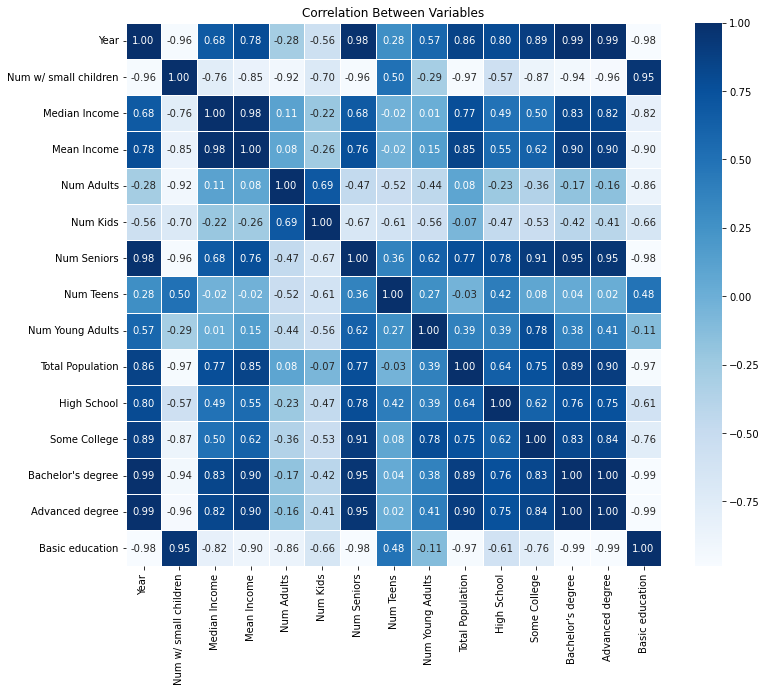

In [32]:
visualize_correlation(correlation_matrix)

## Fill missing values

In [33]:
def linear_interpolation(df, columns, window=None):
    df_ = df.copy()
    for col in columns:
        values_ = df_[col].values
        # Find the indices of known values
        known_indices = np.where(~np.isnan(values_))[0]
    
        # Interpolate between the first and last known values
        first_known_index = known_indices[0]
        if window:
            last_known_index = known_indices[min(first_known_index+window, len(known_indices)-1)]
        else:
            last_known_index = known_indices[-1]
    
        # Number of missing values to interpolate
        num_missing = last_known_index - first_known_index
    
        # Calculate the step between values
        step = (values_[last_known_index] - values_[first_known_index]) / (num_missing + 1)
    
        # Perform linear interpolation
        interpolated_values = []
        for i in range(0, first_known_index):
            interpolated_value = values_[first_known_index] - step * (first_known_index - i)
            interpolated_values.append(interpolated_value)
        
        values_[:first_known_index] = interpolated_values
        
        df_[col] = values_
    
    return df_

In [34]:
merged_data_clean = merged_data.copy()

In [35]:
merged_data_clean = linear_interpolation(df=merged_data_clean, columns=merged_data_clean.columns.values)

In [36]:
merged_data_clean

,Year,Num w/ small children,Median Income,Mean Income,Num Adults,Num Kids,Num Seniors,Num Teens,Num Young Adults,Total Population,High School,Some College,Bachelor's degree,Advanced degree,Basic education
0,1999,33485000.0,67650,90990,151358600.0,64529000.0,25607400.0,19934400.0,19653800.0,2.810852e+08,6.658568e+07,5.622953e+07,3.062268e+07,1.431447e+07,51486500.0
1,2000,33255875.0,67470,91810,151256450.0,63567750.0,27764050.0,19996050.0,19711350.0,2.822977e+08,6.692895e+07,5.670542e+07,3.169695e+07,1.507258e+07,50896812.5
2,2001,33026750.0,66360,91470,151154300.0,62606500.0,29920700.0,20057700.0,19768900.0,2.835101e+08,6.727221e+07,5.718132e+07,3.277121e+07,1.583068e+07,50307125.0
3,2002,32797625.0,65820,89790,151052150.0,61645250.0,32077350.0,20119350.0,19826450.0,2.847226e+08,6.761547e+07,5.765721e+07,3.384547e+07,1.658879e+07,49717437.5
4,2003,32568500.0,65860,89810,150950000.0,60684000.0,34234000.0,20181000.0,19884000.0,2.859350e+08,6.795874e+07,5.813311e+07,3.491974e+07,1.734689e+07,49127750.0
5,2004,32339375.0,65760,89690,152217000.0,60752000.0,34659000.0,20313000.0,20339000.0,2.882820e+08,6.830200e+07,5.860900e+07,3.599400e+07,1.810500e+07,48538062.5
6,2005,32110250.0,66780,91310,154158000.0,40467000.0,35210000.0,20662000.0,20408000.0,2.709070e+08,6.944600e+07,5.927600e+07,3.652000e+07,1.822500e+07,47948375.0
7,2006,31881125.0,67520,93260,156380000.0,60640000.0,35505000.0,20916000.0,20393000.0,2.938360e+08,6.954800e+07,6.061500e+07,3.733400e+07,1.873400e+07,47358687.5
8,2007,31652000.0,68610,92340,144314000.0,40274000.0,50006000.0,21170000.0,20532000.0,2.762980e+08,7.026600e+07,6.068100e+07,3.894000e+07,1.936400e+07,46769000.0
9,2008,30539000.0,66280,90150,144584000.0,40056000.0,51720000.0,21314000.0,20529000.0,2.782050e+08,6.970200e+07,6.287500e+07,4.009400e+07,2.039600e+07,45080000.0


In [37]:
merged_data_clean.to_csv("dataset/us_census_merged_clean.csv", index=False)